In [306]:
import simplejson
import requests
from requests_oauthlib import OAuth1
import time
import tweepy
import time
from textblob import TextBlob
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display


In [308]:
# Twitter API credentials saved in json file
with open('twitter-api.json') as file:    
    secrets = simplejson.load(file)

### Gallup Wellbeing index

Gallup calculates a "Well-being index" based on the states' rankings in five categories (Purpose, Social, Financial, Community, Physical). This research can be found at http://www.well-beingindex.com/.

In [310]:
# Manually extracted from PDF file
wellbeing = {'Hawaii': 65.2,
            'Alaska': 64.0,
            'South Dakota': 63.7,
            'Maine': 63.6,
            'Colorado': 63.5,
            'Vermont': 63.5,
            'Arizona': 63.4,
            'Montana': 63.2,
            'Minnesota': 63.2,
            'Texas': 63.1,
            'Florida': 63.1,
            'Wyoming': 63.0,
            'California': 63.0,
            'Massachusetts': 63.0,
            'Nebraska': 62.9,
            'North Dakota': 62.8,
            'Utah': 62.8,
            'Idaho': 62.7,
            'Iowa': 62.6,
            'New Mexico': 62.6,
            'Virginia': 62.6,
            'New Hampshire': 62.6,
            'Washington': 62.5,
            'Oregon': 62.5,
            'New Jersey': 62.5,
            'North Carolina': 62.4,
            'South Carolina': 62.3,
            'Wisconsin': 62.3,
            'Georgia': 62.3,
            'Pennsylvania': 62.1,
            'Maryland': 62.0,
            'Kansas': 61.8,
            'New York State': 61.8,
            'Nevada': 61.8,
            'Connecticut': 61.7,
            'Missouri': 61.7,
            'Illinois': 61.6,
            'Tennessee': 61.5,
            'Michigan': 61.4,
            'Delaware': 61.4,
            'Mississippi': 61.3,
            'Rhode Island': 61.3,
            'Louisiana': 61.0,
            'Alabama': 61.0,
            'Ohio': 60.9,
            'Arkansas': 60.8,
            'Indiana': 60.5,
            'Oklahoma': 60.5,
            'Kentucky': 60.5,
            'West Virginia': 58.9}

To find a similar amount of tweets from each of the states, we need to create separate search queries for each. Unfortunately the Twitter Search API doesn't allow using the 'near' search parameter for some reason, so we must provide a geolocation parameter instead. To do this, we use the Nominatim Search API from OpenStreetMap, where we just provide the name of the state, and retrieve the geocoordinates of a bounding box.

In [311]:
data = []
for state in wellbeing.keys():
    params = {'q':state, 'format':'json', 'key':secrets['mapquestkey']} 
#     r = requests.get('http://nominatim.openstreetmap.org/search', params=params) #This got rate blocked
    r = requests.get('http://open.mapquestapi.com/nominatim/v1/search.php', params=params)
    json = r.json()
    data.append({'state': state,'wellbeing':wellbeing[state], 'nominatim_name': json[0]['display_name'], 'boundingbox':json[0]['boundingbox']})

In [313]:
# Function to convert a bounding box to lat-long point and radius.
# Radius gives a circle contained within the bounding box to avoid excessive overlap
def bb2radius(bb):
    R = 6371 #km
    bb = list(map(lambda x: float(x), bb))
    lat=(bb[1]+bb[0])/2.0  #deg
    long = (bb[3]+bb[2])/2.0
    dy = (bb[1]-bb[0])/360.0 * 2*np.pi*R
    dx = (bb[3]-bb[2])/360.0 * 2*np.pi*R*np.cos(lat *np.pi/180)
    radius = int(min([dx, dy])/2.0)
    return str(lat)+','+str(long)+','+str(radius)+'km'

for state in data:
    state['location'] = bb2radius(state['boundingbox'])
    
print('Example of the resulting data for a state so far:\n')    
pprint(data[0])

Example of the resulting data for a state so far:

{'boundingbox': ['39.7197662', '42.5146891', '-80.5210832', '-74.6895019'],
 'location': '41.117227650000004,-77.60529255,155km',
 'nominatim_name': 'Pennsylvania, United States of America',
 'state': 'Pennsylvania',
 'wellbeing': 62.1}


Now that we have the coordinates and radius for each state, let's set up the Twitter search.

In [265]:

# Set up authentication to use the API
auth = tweepy.AppAuthHandler(secrets['client_key'], secrets['client_secret'])
# auth.set_access_token(secrets['resource_owner_key'], secrets['resource_owner_secret']) #Only needed for User access
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# Loop and collect (up to) 1000 tweets for each state:
for state in data:
    
    state['tweets'] = []
    i=0
    for tweet in tweepy.Cursor(api.search, q="-filter:retweets", geocode = state['location']).items():
        i = i+1
        IPython.display.clear_output(wait=True)
        print('Fetching tweets from',state['state'] ,'tweets:', str(i))
        state['tweets'].append(tweet.text)
        if i>999:
            break


Fetching tweets from New York State tweets: 1000


In [268]:
# Save the fetched data
import pickle

with open('data.pkl', 'wb') as file: 
    pickle.dump(data, file)

### Extracting sentiment score for each tweet

Using the package TextBlob, we assign a sentiment polarity score to each tweet and extract to a vector, with a corresponding vector of the Gallup well-being index. We then perform a linear regression on the relationship between the two variables

In [300]:
x=[]
y=[]
for state in data:
    x.extend([state['wellbeing']]*len(state['tweets']))
    y.extend(list(map(lambda x: TextBlob(x).sentiment.polarity, state['tweets'])))


In [314]:
import statsmodels.api as sm

x = sm.add_constant(x)
result = sm.OLS(y,x).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08902
Date:                Fri, 19 May 2017   Prob (F-statistic):              0.765
Time:                        00:43:53   Log-Likelihood:                -8514.3
No. Observations:               49046   AIC:                         1.703e+04
Df Residuals:                   49044   BIC:                         1.705e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0698      0.074      0.938      0.348        -0.076     0.216
x1             0.0004      0.001      0.298      0.765        -0.002     0.003
==============================================================================
Omnibus:                     4833.535   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13560.732
Skew:                           0.547   Prob(JB):                         0.00
Kurtosis:                       5.332   Cond. No.                     3.56e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [284]:
for state in data:
    state['polarity']=np.mean(list(map(lambda x: TextBlob(x).sentiment.polarity, state['tweets'])))
    state['subjectivity']=np.mean(list(map(lambda x: TextBlob(x).sentiment.subjectivity, state['tweets'])))


In [317]:
plt.scatter(list(map(lambda x: x['wellbeing'], data)), list(map(lambda x: x['polarity'], data)))

KeyError: 'polarity'

ValueError: x and y must be the same size

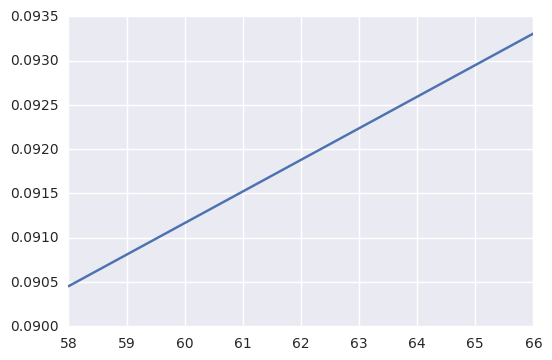

In [316]:
X=range(58,67)
pred=result.predict(sm.add_constant(X))
plt.figure()
plt.plot(X,pred)
plt.scatter(x,y, alpha=0.01)

In [133]:
readtweets =[]
with open('output.txt', 'r') as f:
    for line in f:
        readtweets.append(simplejson.loads(line))
    
print(len(readtweets))
print(len(myStreamListener.tweets))

19
19


(array([ 4.,  8.,  8.,  7.,  5.]),
 array([ 736456.92790509,  736456.92791435,  736456.92792361,
         736456.92793287,  736456.92794213,  736456.92795139]),
 <a list of 5 Patch objects>)

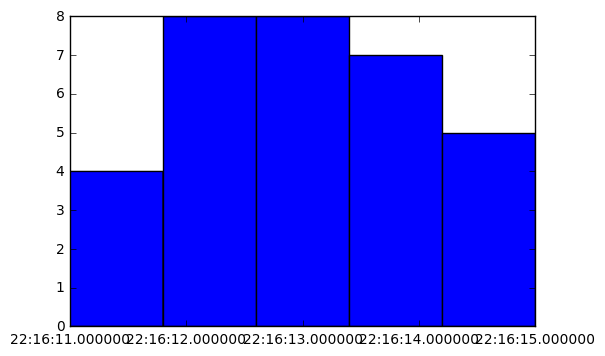

In [65]:
timestamps = list(map(lambda tweet: tweet['created_at'], myStreamListener.tweets))
plt.hist(timestamps,5)

In [27]:
myStreamListener.tweets[0]

Status(is_quote_status=False, id_str='861328127166992384', filter_level='low', in_reply_to_status_id=None, retweeted_status=Status(is_quote_status=False, id_str='861287637189046272', retweeted=False, truncated=False, in_reply_to_user_id_str=None, in_reply_to_screen_name=None, text="after brexit and trump i didn't have much hope for these elections but thank god MLP is not the bloody president of this country 🇫🇷", place=None, id=861287637189046272, source_url='http://twitter.com/download/iphone', _json={'is_quote_status': False, 'retweeted': False, 'truncated': False, 'in_reply_to_status_id_str': None, 'in_reply_to_screen_name': None, 'text': "after brexit and trump i didn't have much hope for these elections but thank god MLP is not the bloody president of this country 🇫🇷", 'in_reply_to_user_id_str': None, 'geo': None, 'place': None, 'user': {'followers_count': 1406, 'notifications': None, 'favourites_count': 24552, 'profile_background_color': 'EBEBEB', 'screen_name': 'jaz_dana', 'stat

In [46]:
testimonial = TextBlob("Debra Messing Goes After Ivanka Trump In Scathing GLAAD Acceptance Speech")
testimonial.sentiment

Sentiment(polarity=-0.6, subjectivity=1.0)

In [106]:
x, y = list(zip(*list(map(lambda tweet: (tweet['tb_polarity'], tweet['tb_subjectivity']), 
                          filter(lambda tweet: tweet['tb_polarity']!=0.0 and tweet['tb_subjectivity']!=0.0, 
                                 myStreamListener.tweets)
                         ))))

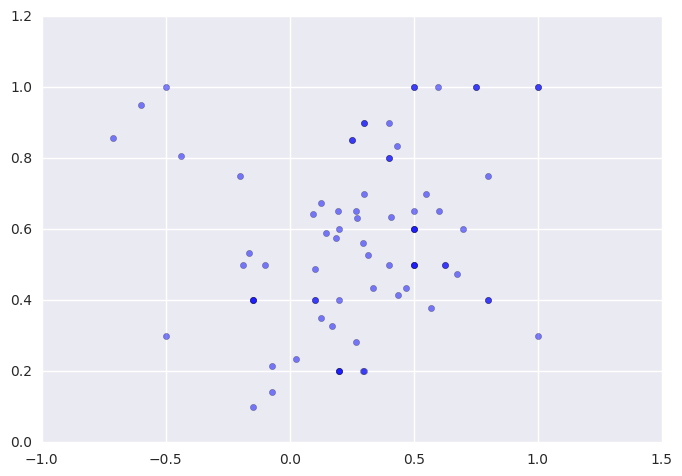

In [108]:
plt.scatter(x,y, alpha=0.5)

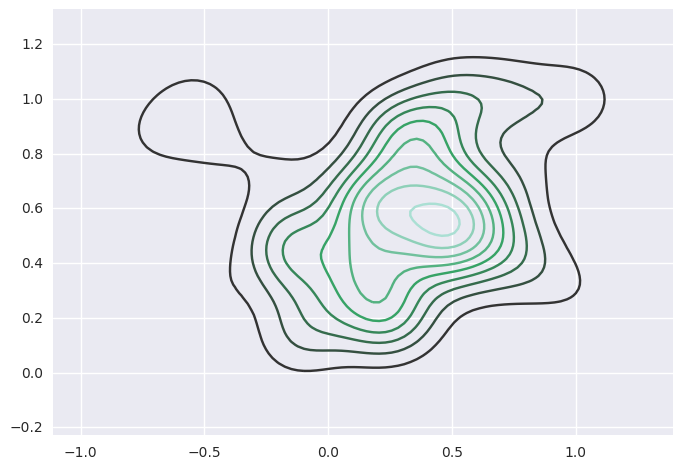

In [107]:
import seaborn as sns
import numpy as np
xy = list(zip(x, y))
sns.kdeplot(np.array(x),np.array(y))

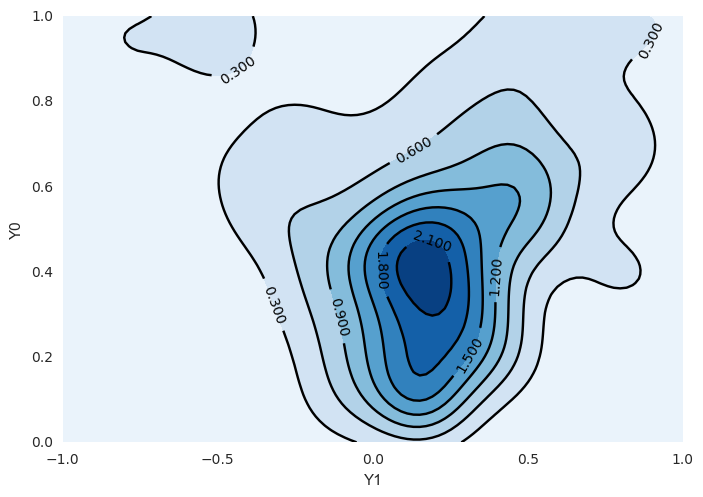

In [103]:
import scipy.stats as st


xmin, xmax = -1, 1
ymin, ymax = 0, 1

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values, bw_method=0.3)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

plt.show()